Implementation of neural network in numpy for digit prediction.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import loadmat

In [2]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

In [3]:
data = loadmat("ex4data1.mat")
data

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [4]:
X = data["X"]
y = data["y"]
print X.shape, y.shape

(5000L, 400L) (5000L, 1L)


In [5]:
from sklearn.preprocessing import OneHotEncoder

In [6]:
encoder = OneHotEncoder(sparse= False)
y_onehot = encoder.fit_transform(y)
print y_onehot.shape

(5000L, 10L)


In [7]:
y[0], y_onehot[0, :]

(array([10], dtype=uint8),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]))

In [9]:
def forward_prop(X, theta1, theta2):
    m = X.shape[0] #number of observations
    
    a1 = np.insert(X, 0, values = np.ones(m), axis=1) #first activation
    z2 = a1 * theta1.T
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1) #second activation
    z3 = a2 * theta2.T
    h = sigmoid(z3) #final output calculation
    
    return a1, z2, a2, z3, h

In [17]:
def cost(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0] #number of observations
    X, y = np.matrix(X), np.matrix(y)
    
    #reshape parameter array into matrices for network layers
    theta1 = np.matrix(np.reshape(params[:hidden_size*(input_size + 1)], (hidden_size, input_size + 1)))
    theta2 = np.matrix(np.reshape(params[hidden_size*(input_size + 1):], (num_labels, hidden_size + 1)))
    
    a1, z2, a2, z3, h = forward_prop(X, theta1, theta2)
    
    J = 0 #compute cost
    for i in range(m):
        first_term = np.multiply(-y[i, :], np.log(h[i, :]))
        second_term = np.multiply(1 - y[i, :], np.log(1 - h[i, :]))
        J += np.sum(first_term - second_term)
        
    J = J / m
    #add regularization of parameters squared excluding bias coefficients
    J += learning_rate/(2.0*m)*(np.sum(np.power(theta1[:, 1:], 2)) + np.sum(np.power(theta2[:, 1:], 2)))
    return J

In [12]:
input_size = 400
hidden_size = 25
num_labels = 10
learning_rate = 1.0

#random initialization of full parameters
params = (np.random.random(size=hidden_size*(input_size + 1) + num_labels*(hidden_size + 1)) -0.5)*0.25

m = X.shape[0]
X, y = np.matrix(X), np.matrix(y)

#unravel parameter array into separate layer matrices
theta1 = np.matrix(np.reshape(params[:hidden_size*(input_size + 1)], (hidden_size, input_size + 1)))
theta2= np.matrix(np.reshape(params[hidden_size*(input_size + 1):], (num_labels, hidden_size + 1)))
print theta1.shape, theta2.shape

(25L, 401L) (10L, 26L)


In [13]:
a1, z2, a2, z3, h = forward_prop(X, theta1, theta2)
print a1.shape, z2.shape, a2.shape, z3.shape, h.shape

(5000L, 401L) (5000L, 25L) (5000L, 26L) (5000L, 10L) (5000L, 10L)


In [19]:
print cost(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)

6.84246697861


In [26]:
def sigmoid_grad(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

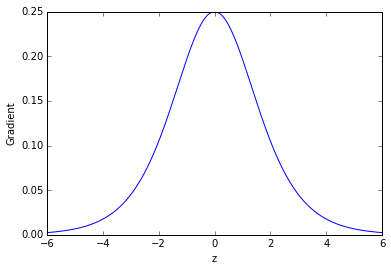

In [25]:
zs = np.arange(-6, 6, 0.01)
grad = sigmoid_grad(zs)
plt.plot(zs, grad)
plt.xlabel("z")
plt.ylabel("Gradient")

In [33]:
def backprop(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0] #number of observations
    X, y = np.matrix(X), np.matrix(y)
    
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, input_size + 1)))
    theta2 = np.matrix(np.reshape(params[hidden_size*(input_size + 1):], (num_labels, hidden_size + 1)))
    
    a1, z2, a2, z3, h = forward_prop(X, theta1, theta2) 
    
    #initialize cost, deltas
    J, delta1, delta2 = 0.0, np.zeros(theta1.shape), np.zeros(theta2.shape)
    
    for i in xrange(m):
        first = np.multiply(-y[i, :], np.log(h[i, :]))
        second = np.multiply(1 - y[i, :], np.log(1 - h[i, :]))
        J += np.sum(first - second)
    J = J / m #calculate cost and add regularization
    J += learning_rate/(2.0*m)*(np.sum(np.power(theta1[:, 1:], 2)) + np.sum(np.power(theta2[:, 1:], 2)))
    
    for t in range(m):
        a1t = a1[t, :] #activations and outputs for t-th training example
        z2t = z2[t, :]
        a2t = a2[t, :]
        ht = h[t, :]
        yt = y[t, :]
        
        d3t = ht - yt #difference between output and prediction
        z2t = np.insert(z2t, 0, values= np.ones(1))
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_grad(z2t)) #delta for hidden layer
        
        delta1 = delta1 + (d2t[:, 1:]).T * a1t #accumulate gradients
        delta2 = delta2 + d3t.T * a2t
        
    delta1 = delta1 / m #unregularized gradients
    delta2 = delta2 / m
    #add gradient regularization terms
    delta1[:, 1:] = delta1[:, 1:] + (theta1[:, 1:] * learning_rate)/m
    delta2[:, 1:] = delta2[:, 1:] + (theta2[:, 1:] * learning_rate)/m
    #unravel gradient matrices into array form
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    return J, grad

In [34]:
J, grad = backprop(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)
print J, grad.shape

6.84246697861 (10285L,)


In [35]:
from scipy.optimize import minimize

In [36]:
fmin = minimize(fun = backprop, x0 = params, args = (input_size, hidden_size, num_labels, X, y_onehot, learning_rate), 
                method = "TNC", jac = True, options = {"maxiter": 250})

In [37]:
fmin

     fun: 0.33840738715694857
     jac: array([ -1.69944847e-04,  -3.79152485e-08,  -3.48881219e-07, ...,
        -1.97928609e-04,  -5.01290789e-04,  -9.74540616e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 21
  status: 3
 success: False
       x: array([ -7.69086621e-01,  -1.89576242e-04,  -1.74440609e-03, ...,
        -1.35086636e+00,   4.94393780e-01,  -1.62288595e+00])

In [41]:
X = np.matrix(X)
theta1 = np.matrix(np.reshape(fmin.x[:hidden_size*(input_size + 1)], (hidden_size, input_size + 1)))
theta2 =np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, hidden_size + 1)))
a1, z2, a2, z3, h = forward_prop(X, theta1, theta2)
y_pred = np.array(np.argmax(h, axis = 1) + 1)
np.unique(y_pred)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [42]:
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
print "Accuracy:", sum(correct) / float(len(correct))

Accuracy: 0.9932


In [46]:
counts = {}
for pred in y_pred:
    if pred[0] in counts:
        counts[pred[0]] += 1
    else:
        counts[pred[0]] = 1
print counts

{1: 504, 2: 497, 3: 498, 4: 501, 5: 501, 6: 498, 7: 501, 8: 500, 9: 496, 10: 504}
